In [301]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# import pywt
from pydmd import DMD
import json
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

class Field:
    def __init__(self, num_points, initial_conditions, dx, dt):
        self.num_points = num_points
        self.values = np.array(initial_conditions)
        self.dx = dx
        self.dt = dt
        self.prev_values = np.copy(self.values)

    def store_prev_values(self):
        self.prev_values = np.copy(self.values)
        
    def operate(self, other, operation):
        # Handling operations with another Field instance
        if isinstance(other, Field):
            # Ensure the fields are compatible for operation
            if self.dx == other.dx and self.dt == other.dt and self.num_points == other.num_points:
                result_values = operation(self.values, other.values)
            else:
                raise ValueError("Fields have different resolutions and cannot be operated directly.")
        # Handling operations with scalars or numpy arrays
        else:
            result_values = operation(self.values, other)
        # Always return a new Field instance with the result
        return Field(self.num_points, result_values, self.dx, self.dt)
        
    def __mul__(self, other):
        return self.operate(other, np.multiply)
        
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __add__(self, other):
        return self.operate(other, np.add)
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __sub__(self, other):
        return self.operate(other, np.subtract)
    
    def __rsub__(self, other):
        # For reverse subtraction, define a custom operation to invert operands
        return self.operate(other, lambda a, b: b - a)
    
    def __truediv__(self, other):
        return self.operate(other, np.divide)
    
    def __rtruediv__(self, other):
        # For reverse division, define a custom operation to invert operands
        return self.operate(other, lambda a, b: b / a)
    
    def __pow__(self, other):
        return self.operate(other, np.power)

    # Comparison operations return numpy boolean arrays, not Field instances
    def __ge__(self, other):
        return self.values >= (other.values if isinstance(other, Field) else other)

    def __le__(self, other):
        return self.values <= (other.values if isinstance(other, Field) else other)

    def __gt__(self, other):
        return self.values > (other.values if isinstance(other, Field) else other)

    def __lt__(self, other):
        return self.values < (other.values if isinstance(other, Field) else other)

    # Specialized, shortened roll functions to prevenet index errors
    def r(self, shift=1):
        return np.roll(self.values, -shift)

    def l(self, shift=1):
        return np.roll(self.values, shift)

    # Derivative Calculators
    def ddx(self, direction='r'):
        """
        Calculate the first derivative using upwinding or central differencing.
        """
        if direction == 'l':
            return (3*self.values - 4*self.l() + self.l(2)) / (2*self.dx)
        elif direction == 'r':
            return (-self.r(2) + 4*self.r() - 3*self.values) / (2*self.dx)
        elif direction == 'c':
            return (self.r() - self.l()) / (2 * self.dx)
        
    def d2dx2(self):
        """
        Calculate the second derivative using central differencing.
        """
        return (self.r() - 2 * self.values + self.l()) / self.dx**2

class Species:
    def __init__(self, density_initial, vel_initial, temp_initial, dx, dt, mass=1.0, gamma=1.0, thermal_diffusivity=0.01):
        self.density = Field(len(density_initial), density_initial, dx, dt)
        self.vel = Field(len(vel_initial), vel_initial, dx, dt)
        self.temp = Field(len(temp_initial), temp_initial, dx, dt)
        self.potential = Field(len(density_initial), np.zeros_like(density_initial), dx, dt)
        self.correlations = Field(len(density_initial), np.zeros_like(density_initial), dx, dt) 
        self.mass = mass
        self.gamma = gamma
        self.thermal_diffusivity = thermal_diffusivity

    def solve_poisson_periodic(self):
        """
        Implement the periodic Poisson solver here using the Modified Thomas Algorithm
        """
        a, b, c = -1.0, 2.0, -1.0
        d = -4 * np.pi * self.density.dx**2 * (self.density.values - np.mean(self.density.values))
        beta_modified = np.full(self.density.num_points, b)
        r_modified = d.copy()
        beta_modified[0] -= a
        beta_modified[-1] -= c
        r_modified[0] -= a * d[-1]
        r_modified[-1] -= c * d[0]

        for i in range(1, self.density.num_points):
            m = a / beta_modified[i-1]
            beta_modified[i] -= m * c
            r_modified[i] -= m * r_modified[i-1]

        # Initialize an array to store the solution of the Poisson equation
        potential_solution = np.zeros(self.density.num_points)
        potential_solution[-1] = r_modified[-1] / beta_modified[-1]
        for i in range(self.density.num_points - 2, -1, -1):
            potential_solution[i] = (r_modified[i] - c * potential_solution[i+1]) / beta_modified[i]
        potential_solution[0] = potential_solution[-1]  # Enforce periodicity

        # Update the potential field values with the solution
        self.potential.values = potential_solution

    ###########
    ## TODO: ##
    ###########
    def calculate_correlations(self):
        """
        Placeholder method for calculating correlations.
        Currently returns a zero array of the same shape as the density.
        This should be replaced with the actual correlation calculation logic.
        """
        # Return zeros for now, as we don't have the actual correlation logic
        self.correlations.values = np.zeros_like(self.density.values)

    def update_density(self):
        """
        Density update using upwind scheme for advection term, with velocity inside the derivative.
        """
        flux_n = np.where(self.vel >= 0,
                          (self.density * self.vel).ddx('l'),
                          (self.density * self.vel).ddx('r'))
        
        self.density.values -= self.density.dt * flux_n

    def update_velocity(self):
        """
        Velocity update using upwind scheme for the advective (nonlinear) term and central differencing for potential gradient.
        """
        # Advective term u * du/dx
        advective_term = np.where(self.vel >= 0,
                                  (self.vel * self.vel.ddx('l')).values,
                                  (self.vel * self.vel.ddx('r')).values)
        
        # Pressure gradient term (1/n) * d(nT)/dx
        pressure_term = (self.density * self.temp).ddx('c') / self.density.values

        # Potential gradient term Gamma * T * dPhi/dx
        dpotential_dx = self.gamma * self.temp.values * self.potential.ddx('c')
        
        # Correlation term - C/n
        correlation_term = self.correlations.ddx('c') / self.density.values
                
        # Update velocity
        self.vel.values -= self.vel.dt * (advective_term - pressure_term + dpotential_dx - correlation_term)

    def update_temperature(self):
        """
        Temperature update using upwind scheme for advection and central differencing for diffusion.
        """
        # Advective term: u * dT/dx
        advective_term = np.where(self.vel >= 0,
                                  self.vel.values * self.temp.ddx('l'),
                                  self.vel.values * self.temp.ddx('r'))

        # Calculate gradients
        dT_dx = self.temp.ddx('c')  # Temperature gradient
        dn_dx = self.density.ddx('c')  # Density gradient

        # Modified diffusive term: (1/n) * (dn/dx) * lambda * dT/dx
        modified_diffusive_term = (1 / self.density.values) * dn_dx * self.thermal_diffusivity * dT_dx

        # Pure diffusion term: lambda * d^2T/dx^2
        diffusion_term = self.thermal_diffusivity * self.temp.d2dx2()

        # Update temperature values
        self.temp.values -= self.temp.dt * (advective_term + modified_diffusive_term + diffusion_term)
        
    def update(self):
        self.density.store_prev_values()
        self.vel.store_prev_values()
        self.temp.store_prev_values()
        
        self.solve_poisson_periodic()
        self.calculate_correlations()
        self.update_density()
        self.update_velocity()
        self.update_temperature()
        
class Orchestrator:
    def __init__(self, species, num_snapshots):
        self.species = species
        self.num_snapshots = num_snapshots
        self.density_snapshots = np.zeros((num_snapshots, species.density.num_points))
        self.vel_snapshots = np.zeros((num_snapshots, species.vel.num_points))
        self.temp_snapshots = np.zeros((num_snapshots, species.temp.num_points))
        self.potential_snapshots = np.zeros((num_snapshots, species.potential.num_points))
        self.snapshot_counter = 0
        self.invalid_run = False

    def take_snapshot(self):
        if self.snapshot_counter < self.num_snapshots:
            if not self.check_invalid_data():
                self.density_snapshots[self.snapshot_counter] = self.species.density.values
                self.vel_snapshots[self.snapshot_counter] = self.species.vel.values
                self.temp_snapshots[self.snapshot_counter] = self.species.temp.values
                self.potential_snapshots[self.snapshot_counter] = self.species.potential.values
                self.snapshot_counter += 1
            else:
                self.invalid_run = True  # Mark the run as invalid and stop further processing

    def check_invalid_data(self):
        if (np.isnan(self.species.density.values).any() or np.isinf(self.species.density.values).any() or
            np.isnan(self.species.vel.values).any() or np.isinf(self.species.vel.values).any() or
            np.isnan(self.species.temp.values).any() or np.isinf(self.species.temp.values).any()):
            return True
        if not (np.all(self.species.density.values > 0) and np.all(self.species.density.values <= 2)):
            return True
        return False
    
    def run_sim(self, num_steps):
        snapshot_interval = max(1, num_steps // self.num_snapshots)
        
        for step in range(num_steps):
            self.species.update()
            
            if step % snapshot_interval == 0 or step == num_steps - 1:
                self.take_snapshot()
                if self.invalid_run:
                    break  # Exit early if invalid data was found            

class Plotter:
    @staticmethod
    def plot_heatmap(data, x_domain, y_domain, title, cmap_type='hot', figsize=(10,6)):
        fig, ax = plt.subplots(figsize=figsize)
        cax = ax.imshow(data, cmap=cmap_type, interpolation='nearest', aspect='auto', 
                        extent=[x_domain[0], x_domain[-1], y_domain[0], y_domain[-1]], origin='lower')
        fig.colorbar(cax)
        ax.set_title(title)
        ax.set_xlabel('Space')
        ax.set_ylabel('Time')
        plt.show(block=False)
        return fig, ax

    @staticmethod
    def plot_line(data_array, x_domain, title, figsize=(10,6)):
        fig, ax = plt.subplots(figsize=figsize)
        for data in data_array:
            ax.plot(x_domain, data)
        ax.set_title(title)
        ax.set_xlabel('Space')
        ax.set_ylabel('Value')
        ax.grid(True)
        plt.show(block=False)
        return fig, ax
    
    @staticmethod
    def plot_fourier_transform(signal, sampling_rate, title='Fourier Transform'):
        N = len(signal)
        T = 1.0 / sampling_rate
        yf = np.fft.fft(signal)
        xf = np.fft.fftfreq(N, T)[:N//2]
        fig, ax = plt.subplots()
        ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
        ax.set_title(title)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Amplitude')
        plt.show(block=False)
        return fig, ax

    @staticmethod
    def plot_2d_fourier_transform(data, title='2D Fourier Transform'):
        """
        Plots the 2D Fourier Transform of the provided data.

        :param data: The 2D data array to transform and plot.
        :param title: The title of the plot.
        """
        # Compute the 2D Fourier Transform
        fourier_transform = np.fft.fft2(data)
        # Shift the zero frequency component to the center of the spectrum
        fshift = np.fft.fftshift(fourier_transform)
        
        # Calculate the magnitude spectrum
        magnitude_spectrum = np.abs(fshift)
        
        fig, ax = plt.subplots()
        # Use logarithmic scaling to better visualize the spectrum
        ax.imshow(magnitude_spectrum, norm=LogNorm(vmin=1), cmap='hot', aspect='equal')
        ax.set_title(title)
        plt.colorbar(ax.imshow(magnitude_spectrum, norm=LogNorm(vmin=1), cmap='hot'), ax=ax)
        plt.show(block=False)
        return fig, ax
    
    @staticmethod
    def plot_wavelet_transform(signal, scales, dt, waveletname='cmor', title='Wavelet Transform'):
        import pywt

        duration = len(signal) * dt
        sampling_rate = 1 / dt

        # Perform the Continuous Wavelet Transform (CWT)
        coefficients, frequencies = pywt.cwt(signal, scales, waveletname, 1 / sampling_rate)
        
        # Plot the wavelet power spectrum
        fig, ax = plt.subplots(figsize=(10, 4))
        
        # Determine the extent of the plot
        extent = [0, duration, 0, len(frequencies) - 1]
        
        # Plot the coefficients with an image plot
        im = ax.imshow(np.abs(coefficients), extent=extent, cmap='jet', aspect='auto', origin='lower', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
        
        # Create an array of y positions from 0 to the number of frequencies, this will be the new y-axis
        y_positions = np.linspace(start=0, stop=len(frequencies) - 1, num=len(frequencies))
        
        # Set the y-ticks to correspond to the positions we just created
        ax.set_yticks(y_positions[::len(y_positions) // 10])
        
        # Set the y-tick labels to show the frequency values
        ax.set_yticklabels(np.round(frequencies, decimals=2)[::len(y_positions) // 10])
        
        # Add the plot details
        ax.set_title(title)
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Frequency (Hz)')
        
        # Add a colorbar for the magnitude
        fig.colorbar(im, ax=ax, label='Magnitude')
        
        plt.show(block=False)
        return fig, ax

    @staticmethod
    def animate_solution(data, x_domain, y_label='Value', title='Solution Evolution', interval=200, cmap_type='hot'):
        """
        Creates an animation of the solution's evolution over time.

        :param data: The data to animate, expected shape is (time_steps, spatial_domain).
        :param x_domain: The spatial domain or x-axis values for the plot.
        :param y_label: Label for the y-axis.
        :param title: The title of the plot.
        :param interval: Time interval between frames in milliseconds.
        :param cmap_type: Colormap for the heatmap.
        """
        fig, ax = plt.subplots()
        ax.set_title(title)
        ax.set_xlabel('Space')
        ax.set_ylabel(y_label)
        
        # Setting the limits for x and y axes
        ax.set_xlim(x_domain[0], x_domain[-1])
        ax.set_ylim(np.min(data), np.max(data))
          
        line, = ax.plot([], [], lw=2)

        def init():
            line.set_data([], [])
            return line,

        def animate(i):
            y = data[i]
            line.set_data(x_domain, y)
            return line,

        anim = FuncAnimation(fig, animate, init_func=init, frames=len(data), interval=interval, blit=True)

        plt.show(block=True)
        return anim
    
    @staticmethod
    def animate_solution_ipynb(data, x_domain, y_label, title, interval, cmap_type='viridis'):
        fig, ax = plt.subplots()
        ax.set_title(title)
        ax.set_xlabel('Space')
        ax.set_ylabel(y_label)
        ax.set_xlim(x_domain[0], x_domain[-1])
        ax.set_ylim(np.nanmin(data), np.nanmax(data))

        # Set the face colors to be visible on dark backgrounds
        # ax.set_facecolor('white')
       
        # Create a border around the figure for visibility
        fig.patch.set_linewidth(2)
        fig.patch.set_facecolor('white')
        
        line, = ax.plot([], [], lw=2)
        
        def init():
            line.set_data([], [])
            return line,
        
        def animate(i):
            y = data[i]
            line.set_data(x_domain, y)
            return line,
        
        anim = FuncAnimation(fig, animate, init_func=init, frames=len(data), interval=interval, blit=True)
        
        plt.close(fig)  # Close the figure to prevent it from displaying twice
        return HTML(anim.to_jshtml())

if __name__ == "__main__":
    ### Define Parameters & Initial Conditions ###
    # Defined below. JSON file is wrong for initial conditions
    # config_file_path = 'config.json'  # replace with the actual path to your JSON config file
    # orchestrator.set_up(config_file_path)

    # Parameters
    gamma = 1  # Coulomb coupling parameter
    mass = 1  # Mass of particles
    thermal_diffusivity = .1  # Thermal diffusivity
    density_mean = 3 / (4 * np.pi)  # Mean density calculated from ion sphere radius during nondimensionalization
    
    # Spatial and temporal resolution
    L = 10
    grid_size = 100
    dx = L / grid_size
    dt = 0.001

    # Number of snapshots to record
    num_snapshots = 50
    
    x = np.linspace(0, L, grid_size, endpoint=False)

    # Initial conditions
    # Define functions for different initial conditions
    def sinusoidal(frequency, phase):
        return np.sin(frequency * x + phase)

    def gaussian(mean, std_dev):
        return np.exp(-((x - mean)**2 / (2 * std_dev**2)))

    def constant(value):
        return np.full_like(x, value)

    def random(low, high):
        return np.random.uniform(low, high, size=x.shape)

    def zero():
        return np.zeros_like(x)

    # Parameters for the initial conditions
    initial_conditions_params = {
        'sinusoidal': {'frequency': 2*np.pi / L, 'phase': 0},
        'gaussian': {'mean': L/2, 'std_dev': 1},
        'constant': {'value': 1},
        'random': {'low': -0.1, 'high': 0.1},
        'zero': {}
    }
    
    # Select the initial condition types for density, velocity, and temperature. Options: 'sinusoidal', 'gaussian', 'constant', 'random', 'zero'
    initial_density_type = 'gaussian'
    initial_velocity_type = 'sinusoidal'
    initial_temperature_type = 'sinusoidal'
    
    density_equilibrium = density_mean
    velocity_equilibrium = 1
    temperature_equilibrium = 1

    initial_density_pertubation_amplitude = .01
    initial_velocity_pertubation_amplitude = .01
    initial_temperature_pertubation_amplitude = .1
    
    # Initialize initial conditions based on the selected types
    initial_density = density_equilibrium + initial_density_pertubation_amplitude * globals()[initial_density_type](**initial_conditions_params[initial_density_type])
    initial_vel = velocity_equilibrium + initial_velocity_pertubation_amplitude * globals()[initial_velocity_type](**initial_conditions_params[initial_velocity_type])
    initial_temp = temperature_equilibrium + initial_temperature_pertubation_amplitude * globals()[initial_temperature_type](**initial_conditions_params[initial_temperature_type])

    initial_density = np.roll(initial_density, int(grid_size / 2))
    initial_vel = np.roll(initial_vel, int(grid_size / 2))
    initial_temp = np.roll(initial_temp, int(grid_size / 2)) 
    
    # Create species object with explicit parameters
    species = Species(initial_density, initial_vel, initial_temp, dx, dt, mass, gamma, thermal_diffusivity)

    # Initialize the orchestrator with species
    orchestrator = Orchestrator(species, num_snapshots)
    num_steps = 300  # number of simulation steps
    time = np.linspace(0, int(dt*num_steps), num_steps, endpoint=False)
    orchestrator.run_sim(num_steps)
    
    ####################
    ### Check Values ###
    ####################
    
    # Check for NaN or Inf values
    print("Contains NaN:", np.isnan(orchestrator.density_snapshots).any())
    print("Contains Inf:", np.isinf(orchestrator.density_snapshots).any())

Contains NaN: False
Contains Inf: False


In [334]:
import numpy as np

def sinusoidal(x, frequency, phase):
    return np.sin(frequency * x + phase)

def gaussian(x, mean, std_dev):
    return np.exp(-((x - mean) ** 2 / (2 * std_dev ** 2)))

def constant(x, value):
    return np.full_like(x, value)

def random_noise(x, low, high):
    return np.random.uniform(low, high, size=x.shape)

def zero(x):
    return np.zeros_like(x)

def run_simulation_with_dynamic_conditions(num_samples, grid_size, num_snapshots, num_steps, L, dx, dt):
    density_mean = 3 / (4 * np.pi)
    x = np.linspace(0, L, grid_size, endpoint=False)

    data = []
    initial_condition_types_array = []
    initial_condition_params_array = []
    initial_condition_equilibria_array = []
    initial_condition_perturbation_amplitudes_array = []

    while len(data) < num_samples:
        initial_condition_types = np.random.choice(['sinusoidal', 'gaussian', 'constant', 'random_noise', 'zero'], 3, replace=True)
        initial_condition_params = {
            'sinusoidal': {'frequency': 2*np.pi / L, 'phase': np.random.uniform(0, 2*np.pi)},
            'gaussian': {'mean': np.random.uniform(L*0.25, L*0.75), 'std_dev': np.random.uniform(0.5, 2)},
            'constant': {'value': np.random.uniform(0.5, 1.5)},
            'random_noise': {'low': -0.1, 'high': 0.1},
            'zero': {}
        }

        initial_density_type = globals()[initial_condition_types[0]](x, **initial_condition_params[initial_condition_types[0]])
        initial_velocity_type = globals()[initial_condition_types[1]](x, **initial_condition_params[initial_condition_types[1]])
        initial_temperature_type = globals()[initial_condition_types[2]](x, **initial_condition_params[initial_condition_types[2]])

        # Generate random initial equilibrium conditions
        density_equilibrium = density_mean
        velocity_equilibrium = np.random.uniform(-5, 5)
        temperature_equilibrium = np.random.uniform(0, 1)

        # Generate random perturbation amplitude
        initial_perturbation_amplitudes = np.random.choice([0.0001, 0.001, 0.01, 0.1], 3, replace=True)
        initial_density_perturbation_amplitude = initial_perturbation_amplitudes[0]
        initial_velocity_perturbation_amplitude = initial_perturbation_amplitudes[1]
        initial_temperature_perturbation_amplitude = initial_perturbation_amplitudes[2]

        # Initialize initial conditions based on the selected types
        initial_density = density_equilibrium + initial_density_perturbation_amplitude * initial_density_type
        initial_vel = velocity_equilibrium + initial_velocity_perturbation_amplitude * initial_velocity_type
        initial_temp = temperature_equilibrium + initial_temperature_perturbation_amplitude * initial_temperature_type

        # Roll to introduce asymmetry
        roll_shift = np.random.randint(0, grid_size)
        initial_density = np.roll(initial_density, roll_shift)
        initial_vel = np.roll(initial_vel, roll_shift)
        initial_temp = np.roll(initial_temp, roll_shift)

        species = Species(initial_density, initial_vel, initial_temp, dx, dt)
        orchestrator = Orchestrator(species, num_snapshots)
        orchestrator.run_sim(num_steps)

        if not orchestrator.invalid_run:
            data_sample = np.stack([
                orchestrator.density_snapshots,
                orchestrator.vel_snapshots,
                orchestrator.temp_snapshots
            ], axis=0)  # Shape: (3, num_snapshots, num_points)
            data.append(data_sample)
            initial_condition_types_array.append(initial_condition_types)
            initial_condition_params_array.append(initial_condition_params)
            initial_condition_equilibria_array.append(np.array([density_equilibrium, velocity_equilibrium, temperature_equilibrium]))
            initial_condition_perturbation_amplitudes_array.append(initial_perturbation_amplitudes)

    data = np.array(data)
    initial_condition_types_array = np.array(initial_condition_types_array)
    initial_condition_params_array = np.array(initial_condition_params_array)
    initial_condition_equilibria_array = np.array(initial_condition_equilibria_array)
    initial_condition_perturbation_amplitudes_array = np.array(initial_condition_perturbation_amplitudes_array)
    
    return data, initial_condition_types_array, initial_condition_params_array, initial_condition_equilibria_array, initial_condition_perturbation_amplitudes_array

# Simulation parameters
num_samples = 100
grid_size = 100
num_snapshots = 50
num_steps = 1000
L = 10
dx = L / grid_size
dt = 0.001

# Generate data
training_data, IC_types_train, IC_params_train, IC_equilibria_train, IC_pertubration_amplitudes_train = run_simulation_with_dynamic_conditions(num_samples, grid_size, num_snapshots, num_steps, L, dx, dt)
testing_data, IC_types_test, IC_params_test, IC_equilibria_test, IC_pertubration_amplitudes_test = run_simulation_with_dynamic_conditions(num_samples, grid_size, num_snapshots, num_steps, L, dx, dt)

# Save the data to disk for later use
np.savez('simulation_data.npz', training_data=training_data, testing_data=testing_data)

In [1]:
print(training_data.shape)
sample_idx = int(np.random.uniform(len(training_data)))
Plotter.plot_line(training_data[sample_idx, 0], x, 'Density')
Plotter.plot_line(training_data[sample_idx, 1], x, 'Velocity')
Plotter.plot_line(training_data[sample_idx, 2], x, 'Temperature')

print(testing_data.shape)
sample_idx = int(np.random.uniform(len(testing_data)))
Plotter.plot_line(training_data[sample_idx, 0], x, 'Density')

NameError: name 'training_data' is not defined

(50, 100)


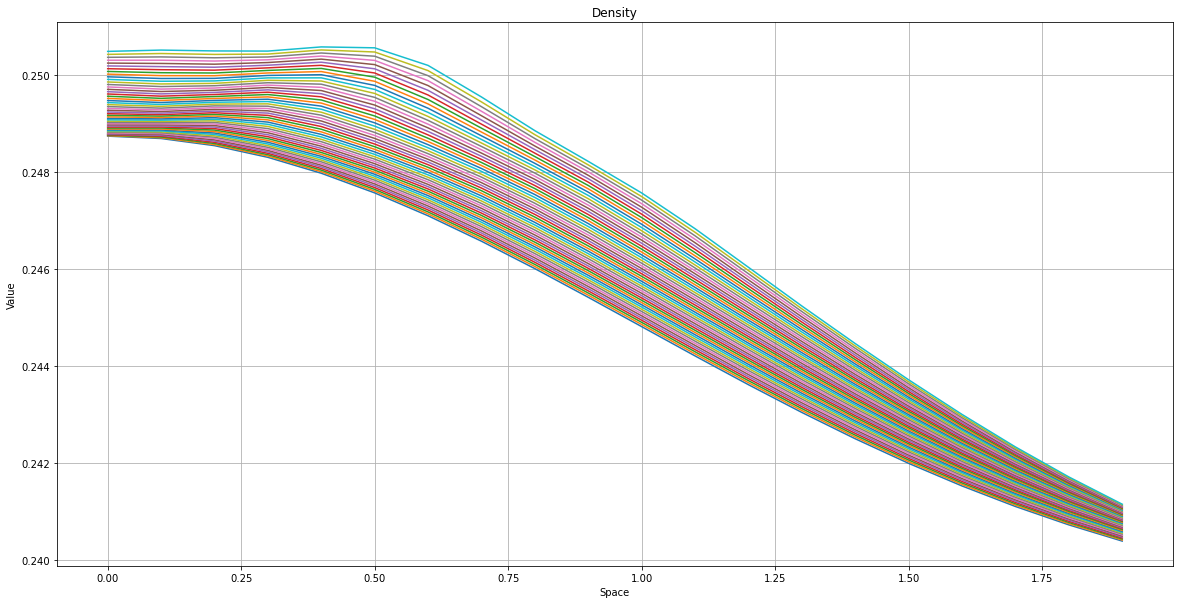

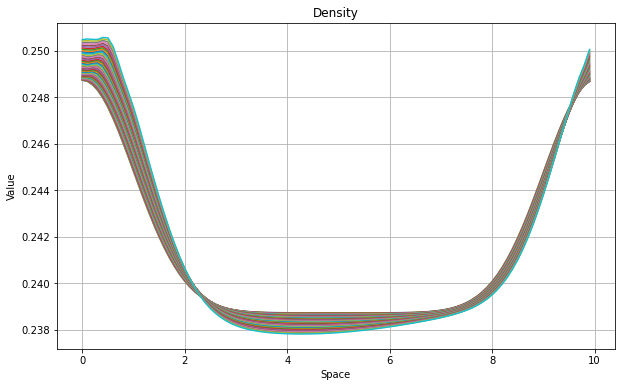

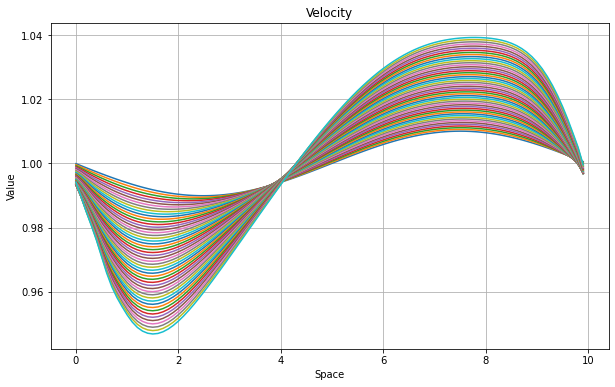

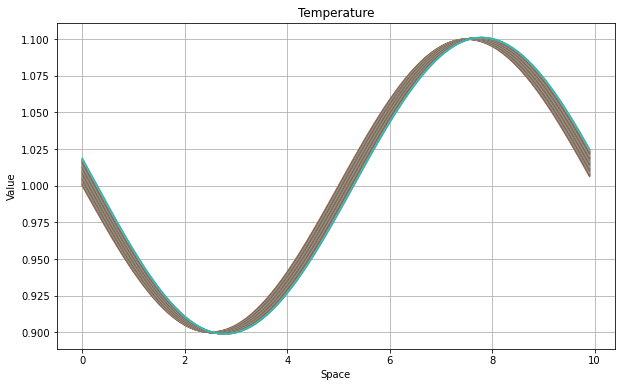

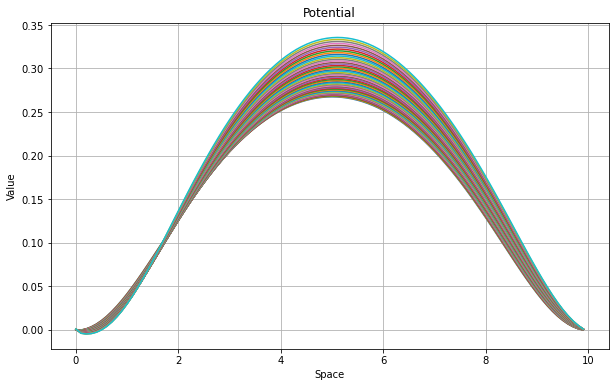

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Potential'}, xlabel='Space', ylabel='Value'>)

In [313]:
Plotter.plot_line(orchestrator.density_snapshots[:,:len(x)//5], x[:len(x)//5], 'Density', figsize=(20,10))
Plotter.plot_line(orchestrator.density_snapshots, x, 'Density')
Plotter.plot_line(orchestrator.vel_snapshots, x, 'Velocity')
Plotter.plot_line(orchestrator.temp_snapshots, x, 'Temperature')
Plotter.plot_line(orchestrator.potential_snapshots, x, 'Potential')

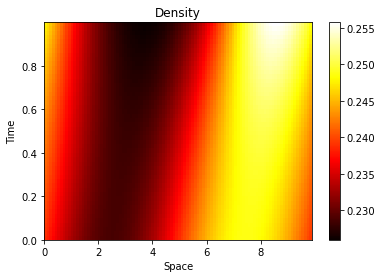

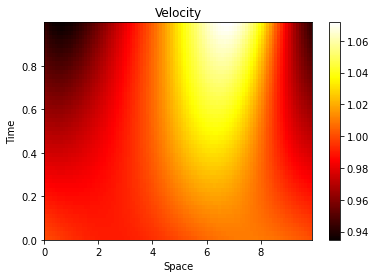

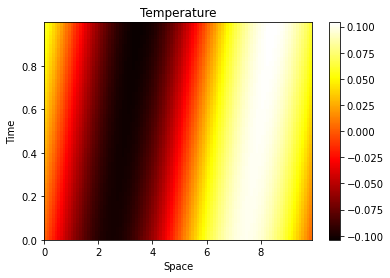

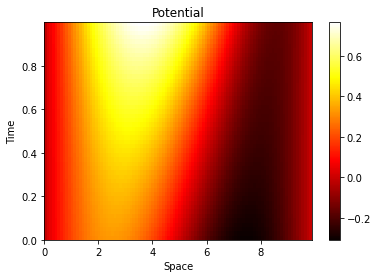

In [252]:
##########
## Plot ##
##########
density_heatmap = Plotter.plot_heatmap(orchestrator.density_snapshots, x, time, 'Density', cmap_type='hot')
velocity_heatmap = Plotter.plot_heatmap(orchestrator.vel_snapshots, x, time, 'Velocity', cmap_type='hot')
temperature_heatmap = Plotter.plot_heatmap(orchestrator.temp_snapshots, x, time, 'Temperature', cmap_type='hot')
potential_heatmap = Plotter.plot_heatmap(orchestrator.potential_snapshots, x, time, 'Potential', cmap_type='hot')

In [253]:
# Display animation in the Jupyter Notebook
density_animation_html = Plotter.animate_solution_ipynb(orchestrator.density_snapshots, x, 'Density', 'Density Solution Evolution', 200, 'hot')
display(density_animation_html)

velocity_animation_html = Plotter.animate_solution_ipynb(orchestrator.vel_snapshots, x, 'Velocity', 'Velocity Solution Evolution', 200, 'hot')
display(velocity_animation_html)

temperature_animation_html = Plotter.animate_solution_ipynb(orchestrator.temp_snapshots, x, 'Temperature', 'Temperature Solution Evolution', 200, 'hot')
display(temperature_animation_html)

potential_animation_html = Plotter.animate_solution_ipynb(orchestrator.potential_snapshots, x, 'Potential', 'Potential Solution Evolution', 200, 'hot')
display(potential_animation_html)

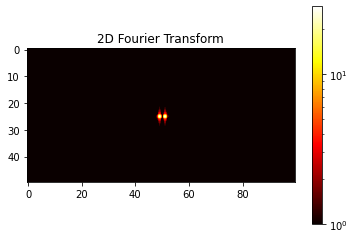

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'2D Fourier Transform'}>)

In [254]:
Plotter.plot_2d_fourier_transform(orchestrator.density_snapshots - np.mean(orchestrator.density_snapshots), title='2D Fourier Transform')

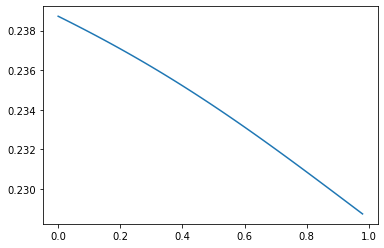

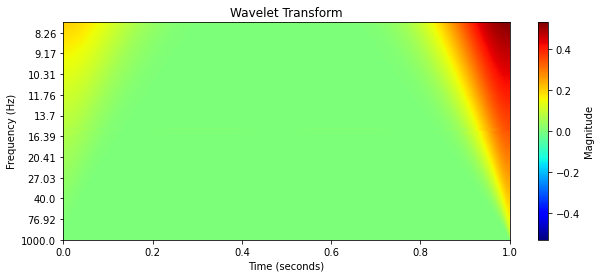

(<Figure size 720x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Wavelet Transform'}, xlabel='Time (seconds)', ylabel='Frequency (Hz)'>)

In [255]:
middle_space_idx = len(orchestrator.density_snapshots[0]) // 2

signal = orchestrator.density_snapshots[:,middle_space_idx]

plt.plot(time[::int(len(time)/num_snapshots)], signal)

signal = np.sin(time)*(time > 5) + np.sin(10 * time)*(time < 5)
scales = np.arange(1,128)
Plotter.plot_wavelet_transform(signal, scales, dt, waveletname='cmor1.5-1.0', title='Wavelet Transform')